In [61]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import integrate
import tensorflow as tf
from scipy.signal import argrelextrema

Hamiltonian for harmonic oscilator <br>
$H = \frac{p^2}{2m} + \frac{1}{2}kq^2$ <br>
$\dot{q} = \frac{p}{m}$<br>
$\dot{p} = kq$


In [62]:
class Oscillator:
    def __init__(self,q,k,m,dt,t_end):
        self.q = q
        self.p = 0
        self.dt = dt
        self.t_end = t_end
        self.k = k
        self.m = m
        
    # Hamiltonian system
    def f(self,t,r):
        q, p = r
        k = self.k
        m = self.m
        
        q_dot = p/m
        p_dot = -k*q 
    
        return q_dot, p_dot
    
    def solve(self):
        traj = integrate.solve_ivp(self.f,(0,t_end),(self.q,self.p),max_step = self.dt, atol = 1, method = 'RK45')
        return np.array((traj.y[0],traj.y[1],traj.t))

In [63]:
# Constants
k = 1
m = 1
dt = 0.02
t_end = 50
# IC's
q = 1

osc_1 = Oscillator(q,k+4,m,dt,t_end)
osc_2 = Oscillator(q,k+8,m,dt,t_end)

traj = np.reshape(np.array(([osc_1.solve()[0] + osc_2.solve()[0]],[osc_1.solve()[1] + osc_2.solve()[1]],[osc_1.solve()[2]])),(3,osc_1.solve().shape[1])) #(q,p,t)

Text(0, 0.5, 'x')

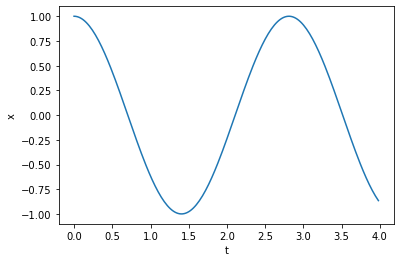

In [64]:
plt.plot(osc_1.solve()[2][0:200],osc_1.solve()[0][0:200])
plt.xlabel('t'); plt.ylabel('x')

Text(0, 0.5, 'x')

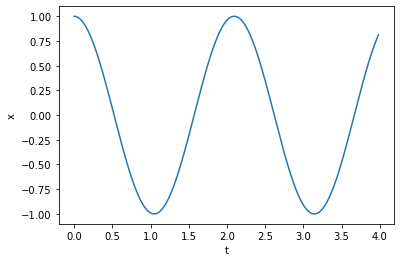

In [65]:
plt.plot(osc_2.solve()[2][0:200],osc_2.solve()[0][0:200])
plt.xlabel('t'); plt.ylabel('x')

Text(0, 0.5, 'x')

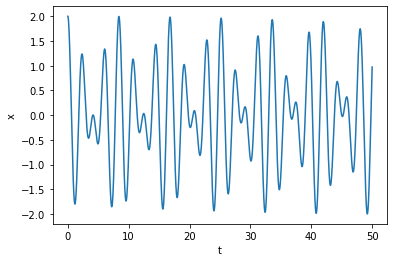

In [66]:
plt.plot(traj[2],traj[0])
plt.xlabel('t'); plt.ylabel('x')

In [67]:
fourierTransform = np.fft.fft(traj[0])/len(traj[0])           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(traj[0])/2))] # Exclude sampling frequency
tpCount     = len(traj[0])
values      = np.arange(int(tpCount/2))
timePeriod  = tpCount/(1/.02)
frequencies = values/timePeriod

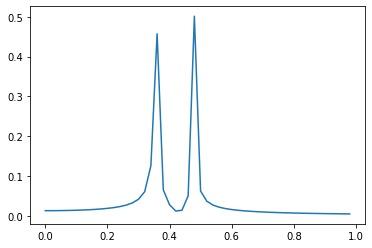

In [68]:
plt.plot(frequencies[0:50], abs(fourierTransform)[0:50])

https://pythontic.com/visualization/signals/fouriertransform_fft

Text(0, 0.5, 'p')

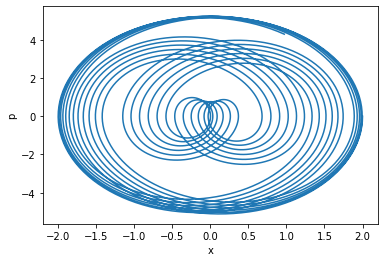

In [69]:
plt.plot(traj[0],traj[1])
plt.xlabel('x'); plt.ylabel('p')

In [70]:
# Convert data to NN format
train_size = 5000
n_M = 50
train_count = 0
train_in = np.zeros((train_size,n_M+1))
train_out_q  = np.zeros((train_size))
train_out_p  = np.zeros((train_size))

for i in range(train_size): # Loop through trajectory
        init_t = int(np.floor(np.random.uniform(0,t_end/dt+1-(n_M+2))))
        # train for theta1
        train_in[train_count,:] = traj[0,init_t:init_t+n_M+1] # n-n_m to n points (ie. current n and all memories)
        train_out_q[train_count] = traj[0,init_t+n_M+1] # n+1 point
        train_out_p[train_count] = traj[1,init_t+n_M+1] # n+1 point
        
        train_count += 1

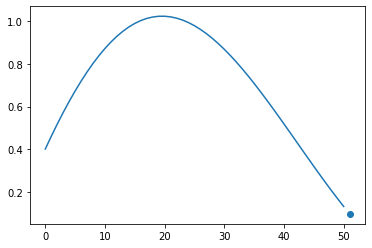

In [71]:
for i in range(1,2):
    plt.plot(train_in[i,:])
    plt.scatter(n_M+1,train_out_q[i])
plt.show()

In [112]:
# MomentumRNN
# First, let's define a momentumRNN Cell, as a layer subclass # https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN
class MomentumRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = [units,units]
        super(MomentumRNNCell, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                      initializer='orthogonal',
                                      name='recurrent_kernel')
        self.built = True
        
    def call(self, inputs, states):
        stepsize = 0.02
        momentum = 0.9
        
        prev_h = states[0]
        prev_v = states[1]
        
        #x = (tf.keras.backend.dot(inputs, self.kernel) + self.bias) * stepsize
        x = (tf.keras.backend.dot(inputs, self.kernel)) * stepsize
        v_out =  prev_v * momentum + x
        h_out = tf.keras.activations.tanh(tf.keras.backend.dot(prev_h, self.recurrent_kernel) + v_out)
        
        return h_out, [h_out, v_out]

inputs = tf.keras.Input((n_M+1,1))

m_rnn, state_h, state_v = tf.keras.layers.RNN(MomentumRNNCell(30),return_state=True)(inputs)

outputs = tf.keras.layers.Dense(1)(m_rnn)
output_momentum = tf.keras.layers.Dense(1)(state_v)
m_rnn_model = tf.keras.Model(inputs,[outputs,output_momentum])
m_rnn_model.summary(line_length = 200)

Model: "model_16"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_17 (InputLayer)                                             [(None, 51, 1)]                             0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_16 (RNN)                                                      [(None, 30), (None, 30), (None, 30)]        930                     input_17[0][0]                              

In [113]:
inputs = tf.keras.Input((n_M+1,1))
m_rnn = tf.keras.layers.RNN(MomentumRNNCell(30))(inputs)
outputs = tf.keras.layers.Dense(1)(m_rnn)
m_rnn_model_2 = tf.keras.Model(inputs,outputs)
m_rnn_model_2.summary(line_length = 200)

Model: "model_17"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_18 (InputLayer)                                                                     [(None, 51, 1)]                                                                 0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_17 (RNN)                                                                              (None, 30)                                                                      930     

In [97]:
inputs = tf.keras.Input((n_M+1,1))
m_rnn = tf.keras.layers.RNN(tf.keras.layers.SimpleRNNCell(30))(inputs)
outputs = tf.keras.layers.Dense(1)(m_rnn)
m_rnn_model_3 = tf.keras.Model(inputs,outputs)
m_rnn_model_3.summary(line_length = 200)

Model: "model_14"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_15 (InputLayer)                                                                     [(None, 51, 1)]                                                                 0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_14 (RNN)                                                                              (None, 30)                                                                      960     

In [98]:
inputs = tf.keras.Input((n_M+1,1))
m_rnn = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(30))(inputs)
outputs = tf.keras.layers.Dense(1)(m_rnn)
m_rnn_model_4 = tf.keras.Model(inputs,outputs)
m_rnn_model_4.summary(line_length = 200)

Model: "model_15"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
input_16 (InputLayer)                                                                     [(None, 51, 1)]                                                                 0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
rnn_15 (RNN)                                                                              (None, 30)                                                                      3840    

In [99]:
train_in = np.reshape(train_in,(train_in.shape[0],n_M+1,1))
train_out_q = np.reshape(train_out_q,(train_in.shape[0],1,1))
train_out_p = np.reshape(train_out_p,(train_in.shape[0],1,1))
batch_size = 5;
epochs = 10;

In [114]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model.fit(train_in.astype('float32'),[train_out_q.astype('float32'),train_out_p.astype('float32')],epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model.fit(train_in.astype('float32'),[train_out_q.astype('float32'),train_out_p.astype('float32')],epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model.fit(train_in.astype('float32'),[train_out_q.astype('float32'),train_out_p.astype('float32')],epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 12s 2ms/sample - loss: 5.9350 - dense_20_loss: 0.0656 - dense_21_loss: 5.8694
Epoch 2/10
5000/5000 [==============================] - 12s 2ms/sample - loss: 5.5182 - dense_20_loss: 0.0157 - dense_21_loss: 5.5024
Epoch 3/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 5.5111 - dense_20_loss: 0.0076 - dense_21_loss: 5.5035
Epoch 4/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 5.5050 - dense_20_loss: 0.0031 - dense_21_loss: 5.5019
Epoch 5/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 5.5028 - dense_20_loss: 5.4949e-04 - dense_21_loss: 5.5023
Epoch 6/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 5.5049 - dense_20_loss: 0.0024 - dense_21_loss: 5.5025
Epoch 7/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 5.5028 - dense_20_loss: 0.0020 - dense_21_loss: 5.5008
Epoch 8/10
5000/5000 [==============

In [115]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model_2.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_2.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model_2.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_2.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model_2.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_2.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 12s 2ms/sample - loss: 0.1343
Epoch 2/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0249
Epoch 3/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0146
Epoch 4/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0120
Epoch 5/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0317
Epoch 6/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0126
Epoch 7/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0092
Epoch 8/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0072
Epoch 9/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0074
Epoch 10/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0033


In [102]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model_3.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_3.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model_3.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_3.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model_3.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_3.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0122
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 9.8438e-05
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 4.6769e-05
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 3.7196e-05
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 6.8941e-05
Epoch 6/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 6.0019e-05
Epoch 7/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 2.2823e-05
Epoch 8/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 7.5294e-05
Epoch 9/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 2.2311e-05
Epoch 10/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 2.0907e-05


In [103]:
tf.random.set_seed(0)
optimizer = tf.keras.optimizers.Adam(lr = .001)
m_rnn_model_4.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_4.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=1)

optimizer = tf.keras.optimizers.Adam(lr = .0001)
m_rnn_model_4.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_4.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

optimizer = tf.keras.optimizers.Adam(lr = .00001)
m_rnn_model_4.compile(optimizer=optimizer,loss=tf.keras.losses.MeanSquaredError())
history_m_rnn  = m_rnn_model_4.fit(train_in.astype('float32'),train_out_q.astype('float32'),epochs=epochs,batch_size=batch_size,shuffle=True,verbose=0)

Train on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 11s 2ms/sample - loss: 0.0234
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 3.2276e-04
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/sample - loss: 1.5192e-04
Epoch 4/10
5000/5000 [==============================] - 9s 2ms/sample - loss: 1.0509e-04
Epoch 5/10
5000/5000 [==============================] - 9s 2ms/sample - loss: 1.3539e-04
Epoch 6/10
5000/5000 [==============================] - 9s 2ms/sample - loss: 1.3862e-04
Epoch 7/10
5000/5000 [==============================] - 9s 2ms/sample - loss: 2.3881e-05
Epoch 8/10
5000/5000 [==============================] - 9s 2ms/sample - loss: 1.2231e-04
Epoch 9/10
5000/5000 [==============================] - 9s 2ms/sample - loss: 4.2286e-05
Epoch 10/10
5000/5000 [==============================] - 9s 2ms/sample - loss: 4.9928e-05


In [116]:
length = 2000 #1000
S = np.zeros((1,length+2,2))
S[0,0:n_M+1,0] = traj[0,0:n_M+1]
t = traj[2,0:length+2]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S[0,i+n_M+1,:] = m_rnn_model.predict(np.reshape(S[0,i:i+n_M+1,0],(1,n_M+1,1)))
    
S_2 = np.zeros((1,length+2))
S_2[0,0:n_M+1] = traj[0,0:n_M+1]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S_2[0,i+n_M+1] = m_rnn_model_2.predict(np.reshape(S_2[0,i:i+n_M+1],(1,n_M+1,1)))
    
S_3 = np.zeros((1,length+2))
S_3[0,0:n_M+1] = traj[0,0:n_M+1]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S_3[0,i+n_M+1] = m_rnn_model_3.predict(np.reshape(S_3[0,i:i+n_M+1],(1,n_M+1,1)))
    
S_4 = np.zeros((1,length+2))
S_4[0,0:n_M+1] = traj[0,0:n_M+1]
for i in range(length+3-(n_M+2)): # 0 to 20 by 0.02 in time
    S_4[0,i+n_M+1] = m_rnn_model_4.predict(np.reshape(S_4[0,i:i+n_M+1],(1,n_M+1,1)))

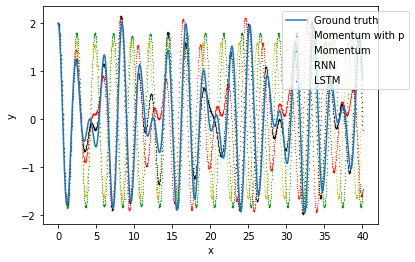

MSE Momentum with p:
1.67e+00
MSE Momentum:
2.55e+00
MSE RNN:
2.23e+00
MSE LSTM:
2.39e-01


In [143]:
fig, ax = plt.subplots(1,1)
plt.plot(traj[2,0:length+2],traj[0,0:length+2])
plt.scatter(traj[2,0:length+2],S[0,:,0],c='r',s=.1)
plt.scatter(traj[2,0:length+2],S_2[0,:],c='g',s=.1)
plt.scatter(traj[2,0:length+2],S_3[0,:],c='y',s=.1)
plt.scatter(traj[2,0:length+2],S_4[0,:],c='k',s=.1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Ground truth','Momentum with p','Momentum','RNN','LSTM'],bbox_to_anchor=(.7, 1), loc='upper left')
plt.show()
MSE = np.mean(np.square(traj[0,0:length+2] - S[0,:,0]))
print('MSE Momentum with p:')
print('{:.2e}'.format(MSE))
MSE = np.mean(np.square(traj[0,0:length+2] - S_2[0,:]))
print('MSE Momentum:')
print('{:.2e}'.format(MSE))
MSE = np.mean(np.square(traj[0,0:length+2] - S_3[0,:]))
print('MSE RNN:')
print('{:.2e}'.format(MSE))
MSE = np.mean(np.square(traj[0,0:length+2] - S_4[0,:]))
print('MSE LSTM:')
print('{:.2e}'.format(MSE))
fig.savefig('harmonic_1_5.png')

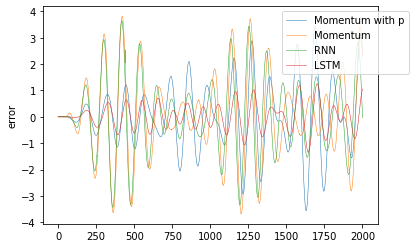

In [132]:
fig, ax = plt.subplots(1,1)
error = traj[0,0:length+2] - S[0,:,0]
plt.plot(error,linewidth=.5)
error = traj[0,0:length+2] - S_2[0,:]
plt.plot(error,linewidth=.5)
error = traj[0,0:length+2] - S_3[0,:]
plt.plot(error,linewidth=.5)
error = traj[0,0:length+2] - S_4[0,:]
plt.plot(error,linewidth=.5)
plt.ylabel('error')
plt.legend(['Momentum with p','Momentum','RNN','LSTM'],bbox_to_anchor=(.7, 1), loc='upper left')
fig.savefig('harmonic_2_5.png')

Text(0, 0.5, 'p')

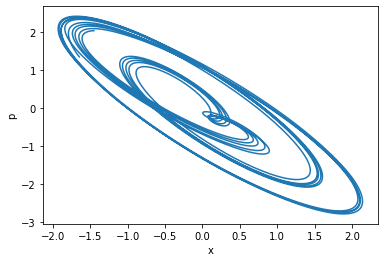

In [133]:
plt.plot(S[0,n_M+1:,0],S[0,n_M+1:,1])
plt.xlabel('x')
plt.ylabel('p')